# 1.0 Import packages and data

In [1]:
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_columns", 80)
pd.set_option("display.max_rows", 80)

# preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA

# modelling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb

# model evaluation

from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, \
                                RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# to create model object
import pickle

In [2]:
df = pd.read_csv('data/cleaned_data.csv', na_filter = True)
df.shape

(3618, 25)

In [3]:
df.head()

,Potential_Customer,Cust_Last_Purchase,Pur_3_years,Pur_5_years,Pur_3_years_Indirect,Pur_5_years_Indirect,Pur_latest,Pur_3_years_Avg,Pur_5_years_Avg,Pur_3_years_Avg_Indirect,InAct_Last,InAct_First,Ad_Res_1_year,Ad_Res_3_Year,Ad_Res_5_Year,Ad_Res_Ind_1_Year,Ad_Res_Ind_3_Year,Ad_Res_Ind_5_Year,Status_Cust,Status_Latest_Ad,Age,Gender,Cust_Prop,Cust_Ann_Income,Status_Cust_new
0,1,5.00,2.00,17.00,2.00,4.00,0.00,7.50,7.76,7.50,14.00,110.00,32.00,48.00,73.00,3.00,12.00,16.00,A,0,71.00,F,H,65957.00,A
1,1,30.00,1.00,7.00,0.00,3.00,25.00,25.00,13.00,NaN,18.00,75.00,13.00,35.00,55.00,6.00,6.00,22.00,A,1,7.00,M,U,0.00,A
2,0,NaN,5.00,12.00,3.00,5.00,15.00,15.00,11.25,14.67,19.00,57.00,14.00,35.00,53.00,6.00,17.00,22.00,S,1,79.00,F,U,0.00,S
3,1,20.00,1.00,11.00,0.00,3.00,20.00,20.00,12.45,NaN,5.00,113.00,17.00,38.00,71.00,8.00,8.00,33.00,A,0,73.00,F,U,76293.00,A
4,1,5.00,3.00,15.00,2.00,7.00,3.00,4.33,3.80,4.00,17.00,118.00,13.00,28.00,63.00,6.00,12.00,24.00,S,1,68.00,F,H,113663.00,S


In [4]:
# ensure data types are correct
CatCols=['Potential_Customer',
        'Status_Latest_Ad',
        'Gender',
        'Cust_Prop',
        'Status_Cust_new']
NumCols=list(set(df.columns)-set(CatCols + ['Status_Cust']))

df[CatCols] = df[CatCols].apply(lambda x: x.astype('category'))
df[NumCols] = df[NumCols].apply(lambda x: x.astype('float64'))
df['Age'] = df['Age'].astype('Int64')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3618 entries, 0 to 3617
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Potential_Customer        3618 non-null   category
 1   Cust_Last_Purchase        1736 non-null   float64 
 2   Pur_3_years               3618 non-null   float64 
 3   Pur_5_years               3618 non-null   float64 
 4   Pur_3_years_Indirect      3618 non-null   float64 
 5   Pur_5_years_Indirect      3618 non-null   float64 
 6   Pur_latest                3618 non-null   float64 
 7   Pur_3_years_Avg           3618 non-null   float64 
 8   Pur_5_years_Avg           3618 non-null   float64 
 9   Pur_3_years_Avg_Indirect  2956 non-null   float64 
 10  InAct_Last                3618 non-null   float64 
 11  InAct_First               3618 non-null   float64 
 12  Ad_Res_1_year             3618 non-null   float64 
 13  Ad_Res_3_Year             3618 non-null   float6

# 2.0 Feature Engineering and Inspection

## 2.1 Feature Engineering

In [6]:
# Creating the total amount of purchase for the customers
df['Pur_5_years_Total']=df['Pur_5_years']*df['Pur_5_years_Avg']
df['Pur_3_years_Total']=df['Pur_3_years']*df['Pur_3_years_Avg']

# Creating the ad response rate
df['Ad_Res_Rate_3_years']=df['Pur_3_years']/(df['Ad_Res_3_Year']+df['Ad_Res_Ind_3_Year']+1)
df['Ad_Res_Rate_5_years']=df['Pur_5_years']/(df['Ad_Res_5_Year']+df['Ad_Res_Ind_5_Year']+1)

# Since some of our data is skewed, we'll employ logarithmic transformation to -
# transform the highly skewed variables to some more normalized variables.
df['log_Pur_3_years_Indirect']=np.log(df['Pur_3_years_Indirect']+1)
df['log_Pur_5_years_Indirect']=np.log(df['Pur_5_years_Indirect']+1)
df['log_Pur_latest']=np.log(df['Pur_latest']+1)
df['log_Pur_3_years']=np.log(df['Pur_3_years']+1)
df['log_Pur_5_years']=np.log(df['Pur_5_years']+1)
df['log_Pur_5_years_Total']=np.log(df['Pur_5_years_Total']+1)
df['log_Pur_3_years_Total']=np.log(df['Pur_3_years_Total']+1)
df['log_Pur_3_years_Avg_Indirect']=np.log(df['Pur_3_years_Avg_Indirect']+1)
df['log_Ad_Res_Rate_3_years']=np.log(df['Ad_Res_Rate_3_years']+1)
df['log_Ad_Res_Rate_5_years']=np.log(df['Ad_Res_Rate_5_years']+1)
df['log_Pur_3_years_Avg']=np.log(df['Pur_3_years_Avg']+1)
df['log_Pur_5_years_Avg']=np.log(df['Pur_5_years_Avg']+1)

NewCols=['Pur_3_years_Total', 'Pur_5_years_Total', 'Ad_Res_Rate_3_years', 'Ad_Res_Rate_5_years',
         'log_Pur_3_years_Indirect', 'log_Pur_5_years_Indirect','log_Pur_latest','log_Pur_3_years', 
         'log_Pur_5_years','log_Pur_5_years_Total', 'log_Pur_3_years_Total',
         'log_Pur_3_years_Avg_Indirect', 'log_Ad_Res_Rate_3_years', 'log_Ad_Res_Rate_5_years',
         'log_Pur_3_years_Avg', 'log_Pur_5_years_Avg']

NewNumCols=NewCols+NumCols

In [7]:
df[NewNumCols+['Potential_Customer']].groupby('Potential_Customer').median().T

Potential_Customer,0,1
Pur_3_years_Total,32.00,33.99
Pur_5_years_Total,79.97,85.00
Ad_Res_Rate_3_years,0.06,0.07
Ad_Res_Rate_5_years,0.11,0.14
log_Pur_3_years_Indirect,0.69,1.10
log_Pur_5_years_Indirect,1.61,1.79
log_Pur_latest,2.77,2.56
log_Pur_3_years,1.39,1.39
log_Pur_5_years,2.20,2.40
log_Pur_5_years_Total,4.39,4.45


## 2.2 Correlation Matrix

We notice several highly correlated numerical features. Instead of manually removing them (which will take a long time!), we'll leave use Principal Component Analysis (PCA) to preprocess this. 

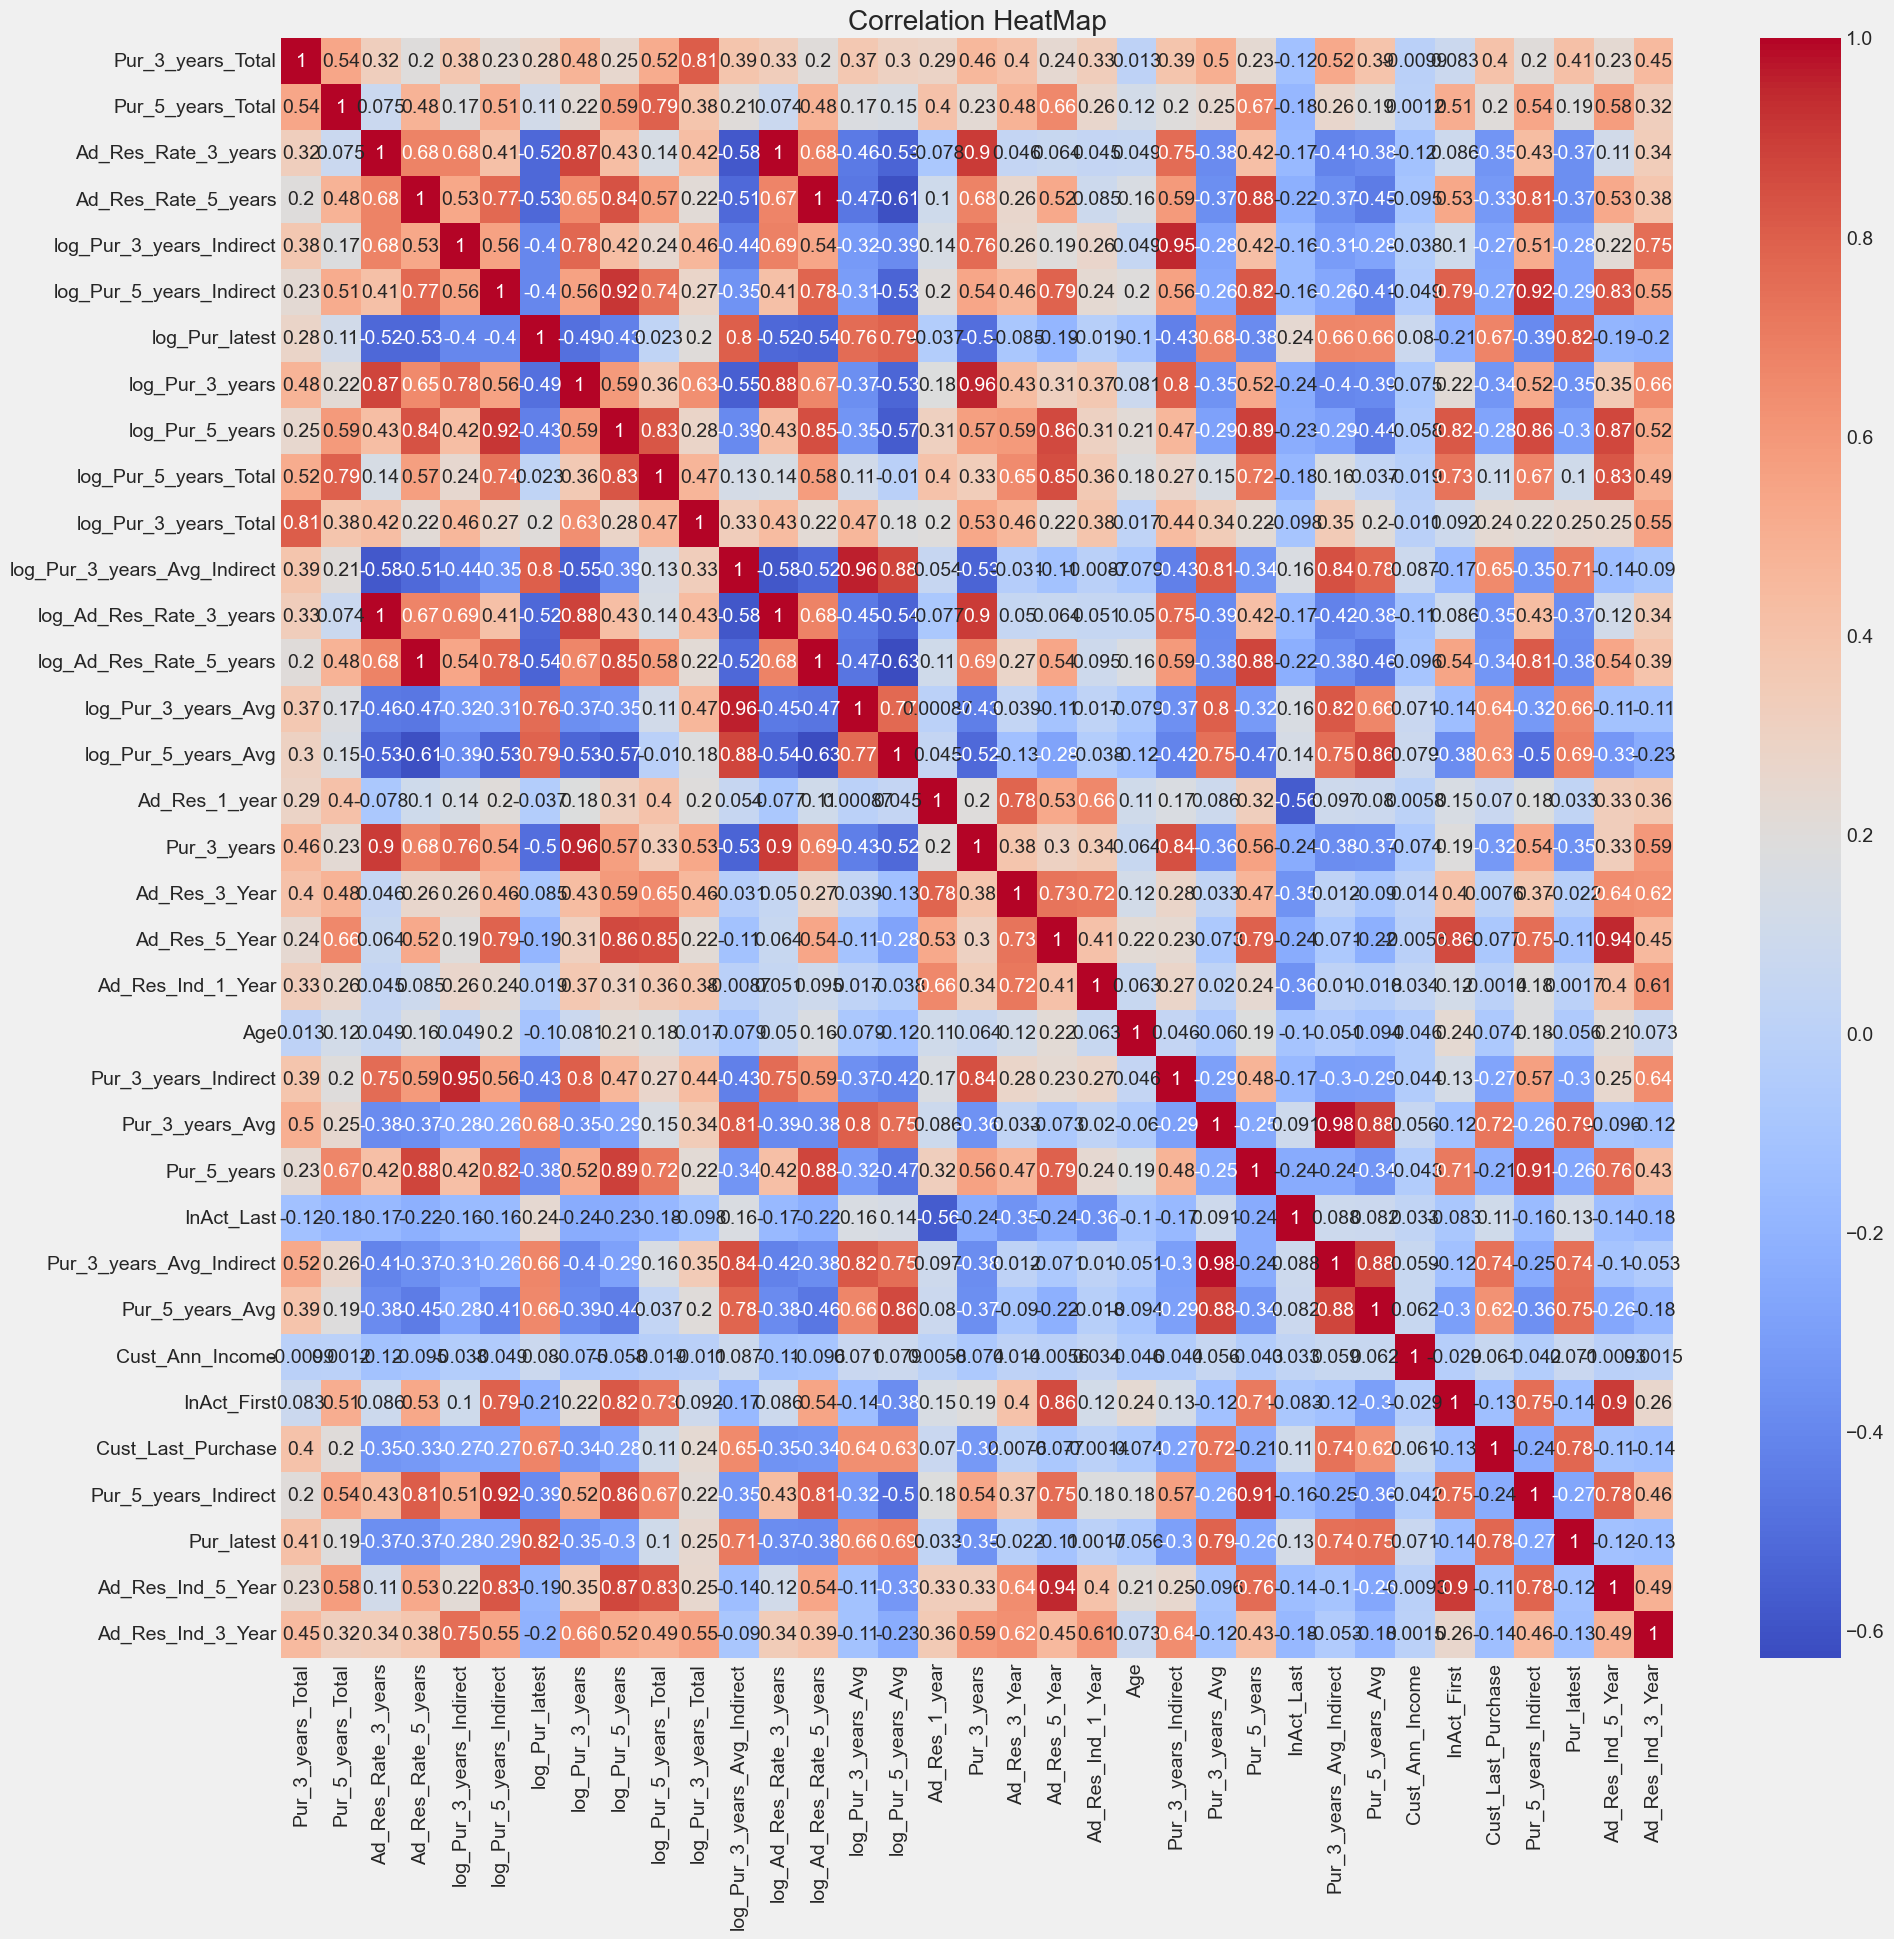

In [8]:
plt.figure(figsize=(20,20))
sns.heatmap(df[NewNumCols].corr(), cmap='coolwarm', annot=True, square=False)
plt.title('Correlation HeatMap');

# 3.0 Data Preprocessing

## 3.1 Split target (Y) and feature (X) variables

In [9]:
# Create list of the categorical features:
CatFes=list(set(CatCols)-set(['Potential_Customer']))

In [10]:
# Split Xs (features) and Y (target)

NewNumCols.remove('Cust_Last_Purchase')
Features=NewNumCols+CatFes
X=df[Features]
y=df['Potential_Customer']

## 3.2 Split data to train/test 

To avoid data leakage, we'll split the data into train and test sets before further preprocessing.

In [11]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
                                 X, y, test_size=0.2, 
                                random_state=42, stratify=y)

"""
Check the average purchase for customers who've made a purchase.
We'll use the value below to benchmark the performance of our model.
"""                                
avg_pur=df[(df.index.isin(X_train.index))&(df.Cust_Last_Purchase>0)]['Cust_Last_Purchase'].mean()
avg_pur

14.556695464362852

## 3.3 Handle null values

In [12]:
# check which columns have null values. 
df.isna().sum()

Potential_Customer                 0
Cust_Last_Purchase              1882
Pur_3_years                        0
Pur_5_years                        0
Pur_3_years_Indirect               0
Pur_5_years_Indirect               0
Pur_latest                         0
Pur_3_years_Avg                    0
Pur_5_years_Avg                    0
Pur_3_years_Avg_Indirect         662
InAct_Last                         0
InAct_First                        0
Ad_Res_1_year                      0
Ad_Res_3_Year                      0
Ad_Res_5_Year                      0
Ad_Res_Ind_1_Year                  0
Ad_Res_Ind_3_Year                  0
Ad_Res_Ind_5_Year                  0
Status_Cust                        0
Status_Latest_Ad                   0
Age                              793
Gender                             0
Cust_Prop                          0
Cust_Ann_Income                    0
Status_Cust_new                    0
Pur_5_years_Total                  0
Pur_3_years_Total                  0
A

In [13]:
# impute with 0 or median. 
X_train.Pur_3_years_Avg_Indirect = X_train.Pur_3_years_Avg_Indirect.fillna(0)
X_test.Pur_3_years_Avg_Indirect = X_test.Pur_3_years_Avg_Indirect.fillna(0)

X_train.log_Pur_3_years_Avg_Indirect = X_train.log_Pur_3_years_Avg_Indirect.fillna(0)
X_test.log_Pur_3_years_Avg_Indirect = X_test.log_Pur_3_years_Avg_Indirect.fillna(0)

X_train.Age = X_train.Age.fillna(int(X_train.Age.median())).astype(int)
X_test.Age = X_test.Age.fillna(int(X_train.Age.median())).astype(int)

# final check for null values
X_train.isna().sum()

Pur_3_years_Total               0
Pur_5_years_Total               0
Ad_Res_Rate_3_years             0
Ad_Res_Rate_5_years             0
log_Pur_3_years_Indirect        0
log_Pur_5_years_Indirect        0
log_Pur_latest                  0
log_Pur_3_years                 0
log_Pur_5_years                 0
log_Pur_5_years_Total           0
log_Pur_3_years_Total           0
log_Pur_3_years_Avg_Indirect    0
log_Ad_Res_Rate_3_years         0
log_Ad_Res_Rate_5_years         0
log_Pur_3_years_Avg             0
log_Pur_5_years_Avg             0
Ad_Res_1_year                   0
Pur_3_years                     0
Ad_Res_3_Year                   0
Ad_Res_5_Year                   0
Ad_Res_Ind_1_Year               0
Age                             0
Pur_3_years_Indirect            0
Pur_3_years_Avg                 0
Pur_5_years                     0
InAct_Last                      0
Pur_3_years_Avg_Indirect        0
Pur_5_years_Avg                 0
Cust_Ann_Income                 0
InAct_First   

## 3.4 Create Dummy Variables

In [14]:
# dummy variables for categorical variables. 
X_train= pd.get_dummies(X_train, drop_first=True).reset_index(drop=True)
X_test= pd.get_dummies(X_test, drop_first=True).reset_index(drop=True)

## 3.5 Feature Scaling

In [15]:
# Power Transformer
scaler_pw=PowerTransformer().fit(X_train[NewNumCols])
X_train_pw=pd.DataFrame(scaler_pw.transform(X_train[NewNumCols]), columns=NewNumCols)
X_test_pw=pd.DataFrame(scaler_pw.transform(X_test[NewNumCols]), columns=NewNumCols)
X_train_pw.index=X_train.index
X_test_pw.index=X_test.index
train_pw=pd.concat([X_train_pw, X_train[['Cust_Prop_U', 'Status_Cust_new_S',
       'Status_Cust_new_other', 'Gender_M', 'Gender_U']]],axis=1)
test_pw=pd.concat([X_test_pw, X_test[['Cust_Prop_U', 'Status_Cust_new_S',
       'Status_Cust_new_other', 'Gender_M', 'Gender_U']]], axis=1)

In [16]:
# MinMax Scaler
scaler=MinMaxScaler().fit(X_train)
X_train_sc=pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_sc=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# 4.0 Feature Selection (PCA)

In [17]:
# PCA on Numerical Columns only
train_PCA=X_train_sc[NewNumCols]
test_PCA=X_test_sc[NewNumCols]

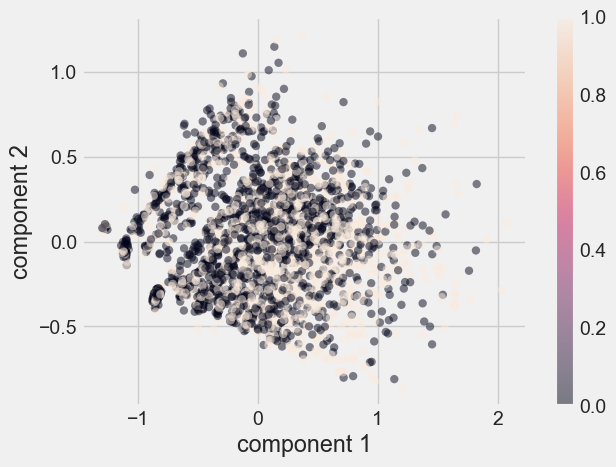

In [18]:
pca = PCA(2)  # project from 34 to 2 dimensions
projected = pca.fit_transform(train_PCA)
plt.scatter(projected[:, 0], projected[:, 1],
            c=y_train, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

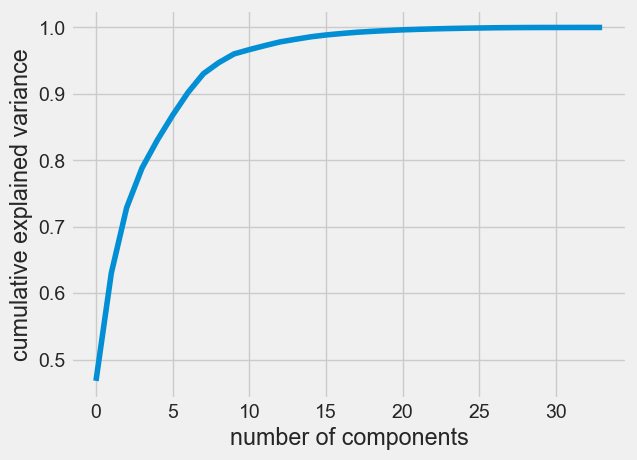

In [19]:
# We'll go with 15 as the ideal number of components after PCA
pca = PCA().fit(train_PCA)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [20]:
pca=PCA(n_components=16).fit(train_PCA)
PCA_train=pd.DataFrame(pca.transform(train_PCA))
PCA_train.index=X_train.index
PCA_test=pd.DataFrame(pca.transform(test_PCA))
PCA_test.index=X_test.index

X_train_pca=pd.concat([PCA_train, X_train[['Cust_Prop_U', 'Status_Cust_new_S',
       'Status_Cust_new_other', 'Gender_M', 'Gender_U']]], axis=1)
X_test_pca=pd.concat([PCA_test, X_test[['Cust_Prop_U', 'Status_Cust_new_S',
       'Status_Cust_new_other', 'Gender_M', 'Gender_U']]], axis=1)

# 5.0 Model building (Machine Learning)

## 5.1 KNN, Logistic Regression, Decision Tree

### 5.1.1 Main

In [21]:
def best_model(train,test,y_train,y_test, model, params,CV=3, **kwargs):
    param_grid = params
    grid = GridSearchCV(model, param_grid, cv=CV, 
                        scoring = 'roc_auc', return_train_score=True)
    grid.fit(train, y_train)
    best_par=grid.best_params_
    best_model = grid.best_estimator_.fit(train,y_train)
    pred=best_model.predict(test)
    F1 = f1_score(y_test, pred)
    best_sc = grid.best_score_
    conf_matrix=confusion_matrix(y_test, pred)
    report=classification_report(y_test, pred)
    return best_par, best_model, best_sc, F1,conf_matrix,report

In [22]:
train_list=[X_train, train_pw,X_train_pca]
test_list=[X_test,test_pw ,X_test_pca]
data_names=['normal', 'powertransform','pca_trans']

models=[KNeighborsClassifier(), DecisionTreeClassifier(), 
       LogisticRegression(solver='saga', max_iter=800)]

knn_param_grid = {'n_neighbors': np.arange(10, 50),
                  'weights':['uniform','distance'],
                  'p': [1,2]}

dt_param_grid = {'max_depth': np.arange(5, 20)}

lr_param_grid = {'C': [0.001, 0.01, 1, 10, 100],
                  'penalty' :['l1','l2']}

params=[knn_param_grid, dt_param_grid,  lr_param_grid]

In [23]:
results=pd.DataFrame({'model':[], 'data':[], 'best_m':[],'best_p':[],'best_sc':[],'TN':[],'FN':[],'FP':[],'TP':[],
                      'F1':[], 'value':[], 'revenue':[]})
i=0
c=5 #cost of ad
for m,p in zip(models, params):
    for tr,te,name in zip(train_list, test_list,data_names ):
        results.loc[i,'model']=str(m)
        results.loc[i,'data']=str(name)
        best_m,best_p,best_sc,F1,conf_matrix,report=best_model(tr,te,y_train,y_test, m, p,CV=3)
        results.loc[i,'best_m']=str(best_m)
        results.loc[i,'best_p']=str(best_p)
        results.loc[i,'best_sc']=round(best_sc,2)
        results.loc[i,'F1']=round(F1,2)
        results.loc[i,'TN']=conf_matrix[0,0]
        results.loc[i,'FN']=conf_matrix[0,1]
        results.loc[i,'FP']=conf_matrix[1,0]
        results.loc[i,'TP']=conf_matrix[1,1]
        cost=(conf_matrix[1,0]+conf_matrix[1,1])*c
        lost=conf_matrix[0,1]*avg_pur
        gain=conf_matrix[1,1]*avg_pur
        value=gain-cost-lost
        revenue= gain-cost
        results.loc[i,'value']=round(value,2)
        results.loc[i,'revenue']=round(revenue)
        print('data: {}\nbest model: {}\nbest param: {}\nbest score = {:.2f}, F1 = {:.2f}\nconfusion matrix: \n{}\
        \n classification report: \n{}\n value: {:.2f} \n revenue: {:.2f}'.\
             format(str(name),best_m,best_p,best_sc,F1,conf_matrix,report,value,revenue))
        print('\n***********************************\n')
        i=i+1

data: normal
best model: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
best param: KNeighborsClassifier(n_neighbors=10, p=1, weights='distance')
best score = 0.52, F1 = 0.47
confusion matrix: 
[[191 186]
 [181 166]]        
 classification report: 
              precision    recall  f1-score   support

           0       0.51      0.51      0.51       377
           1       0.47      0.48      0.47       347

    accuracy                           0.49       724
   macro avg       0.49      0.49      0.49       724
weighted avg       0.49      0.49      0.49       724

 value: -2026.13 
 revenue: 681.41

***********************************

data: powertransform
best model: {'n_neighbors': 48, 'p': 2, 'weights': 'distance'}
best param: KNeighborsClassifier(n_neighbors=48, weights='distance')
best score = 0.58, F1 = 0.51
confusion matrix: 
[[231 146]
 [179 168]]        
 classification report: 
              precision    recall  f1-score   support

           0       0.56      0.61 

### 5.1.2 Threshold-Moving

We can see that the above models have a tendency to predict the negative class (0), slightly better than the positive class (1). We'll use threshold-moving to correct for this. We'll test how lowering the threshold can affect accuracy/recall/precision. 

<a id='bestmodel'></a>

In [82]:
def best_model(train,test,y_train,y_test, model, params,CV=5, **kwargs):
    param_grid = params
    grid = GridSearchCV(model, param_grid, cv=CV, 
                        scoring = 'roc_auc', return_train_score=True)
    grid.fit(train, y_train)
    best_par=grid.best_params_
    best_model = grid.best_estimator_.fit(train,y_train)

    # Obtain the predicted probabilities for each class on the test set
    probs=best_model.predict_proba(test)

    # Define a range of threshold values to try
    thresholds = np.arange(0, 0.45, 0.01)

    # Initialize variables to store the best threshold and best accuracy
    best_threshold = None
    best_score = 0

    # Iterate over the threshold values and evaluate the model's performance
    for threshold in thresholds:
        preds = (probs[:,1] > threshold).astype(int)
        score = accuracy_score(y_test, preds)
        if score > best_score:
            best_threshold = threshold
            best_score = score

    # Use the best threshold to predict the test set and evaluate the model's performance
    preds = (best_model.predict_proba(test)[:,1] > best_threshold).astype(int)
    
    F1 = f1_score(y_test, preds)
    best_sc = grid.best_score_
    conf_matrix=confusion_matrix(y_test, preds)
    report=classification_report(y_test, preds)
    return best_par, best_model, best_sc, F1,conf_matrix,report, best_threshold

In [83]:
train_list=[X_train, train_pw,X_train_pca]
test_list=[X_test,test_pw ,X_test_pca]
data_names=['normal', 'powertransform','pca_trans']

models=[KNeighborsClassifier(), DecisionTreeClassifier(), 
       LogisticRegression(solver='saga', max_iter=800)]

knn_param_grid = {'n_neighbors': np.arange(10, 50),
                  'weights':['uniform','distance'],
                  'p': [1,2]}

dt_param_grid = {'max_depth': np.arange(5, 20)}

lr_param_grid = {'C': [0.001, 0.01, 1, 10, 100],
                  'penalty' :['l1','l2']}

params=[knn_param_grid, dt_param_grid,  lr_param_grid]

In [84]:
results=pd.DataFrame({'model':[], 'data':[], 'best_m':[],'best_p':[],'best_sc':[],'TN':[],'FN':[],'FP':[],'TP':[],
                      'F1':[], 'value':[], 'revenue':[], 'best_threshold':[]})
i=0
c=5 #cost of ad
for m,p in zip(models, params):
    for tr,te,name in zip(train_list, test_list,data_names ):
        results.loc[i,'model']=str(m)
        results.loc[i,'data']=str(name)
        best_m,best_p,best_sc,F1,conf_matrix,report,best_threshold=best_model(tr,te,y_train,y_test, m, p,CV=3)
        results.loc[i,'best_m']=str(best_m)
        results.loc[i,'best_p']=str(best_p)
        results.loc[i,'best_sc']=round(best_sc,2)
        results.loc[i,'F1']=round(F1,2)
        results.loc[i,'TN']=conf_matrix[0,0]
        results.loc[i,'FN']=conf_matrix[0,1]
        results.loc[i,'FP']=conf_matrix[1,0]
        results.loc[i,'TP']=conf_matrix[1,1]
        results.loc[i,'best_threshold']=best_threshold
        cost=(conf_matrix[1,0]+conf_matrix[1,1])*c
        lost=conf_matrix[0,1]*avg_pur
        gain=conf_matrix[1,1]*avg_pur
        value=gain-cost-lost
        revenue= gain-cost
        results.loc[i,'value']=round(value,2)
        results.loc[i,'revenue']=round(revenue)
        print('best threshold: {}\ndata: {}\nbest model: {}\nbest param: {}\nbest score = {:.2f}, F1 = {:.2f}\nconfusion matrix: \n{}\
        \n classification report: \n{}\n value: {:.2f} \n revenue: {:.2f}'.\
             format(best_threshold,str(name),best_m,best_p,best_sc,F1,conf_matrix,report,value,revenue))
        print('\n***********************************\n')
        i=i+1

best threshold: 0.37
data: normal
best model: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
best param: KNeighborsClassifier(n_neighbors=10, p=1, weights='distance')
best score = 0.52, F1 = 0.60
confusion matrix: 
[[ 99 278]
 [ 80 267]]        
 classification report: 
              precision    recall  f1-score   support

           0       0.55      0.26      0.36       377
           1       0.49      0.77      0.60       347

    accuracy                           0.51       724
   macro avg       0.52      0.52      0.48       724
weighted avg       0.52      0.51      0.47       724

 value: -1895.12 
 revenue: 2151.64

***********************************

best threshold: 0.44
data: powertransform
best model: {'n_neighbors': 48, 'p': 2, 'weights': 'distance'}
best param: KNeighborsClassifier(n_neighbors=48, weights='distance')
best score = 0.58, F1 = 0.63
confusion matrix: 
[[157 220]
 [ 85 262]]        
 classification report: 
              precision    recall  f1-score   

## 5.2 XgBoost

### 5.2.1 Main

In [44]:
def best_model(train,test,y_train,y_test, model, params,CV=5, **kwargs):
    param_grid = params
    stf_kf=StratifiedKFold(n_splits=5)
    rscv = RandomizedSearchCV(model,
                            param_distributions=param_grid,
                            cv=stf_kf,
                            n_jobs=-1,
                            scoring='roc_auc',
                            random_state=42)
    rscv.fit(train, y_train, eval_set=[(train, y_train),
                                        (test, y_test)], 
                                        verbose = 0)
    best_par=rscv.best_params_
    best_model = rscv.best_estimator_.fit(train,y_train, 
                                        eval_set=[(train, y_train),
                                                  (test, y_test)], 
                                        verbose = 0)
    pred=best_model.predict(test)
    F1 = f1_score(y_test, pred)
    best_sc = rscv.best_score_
    conf_matrix=confusion_matrix(y_test, pred)
    report=classification_report(y_test, pred)
    return best_par, best_model, best_sc, F1,conf_matrix,report

In [45]:
train_list=[X_train, train_pw,X_train_pca]
test_list=[X_test,test_pw ,X_test_pca]
data_names=['normal', 'powertransform','pca_trans']

models= [xgb.XGBClassifier(n_estimators=1000,
                           n_jobs=-1,
                           random_state=42,
                           early_stopping_rounds= 50)]

xgb_param_grid = {
         'learning_rate': np.arange(0.01, 0.11, 0.025),
         'max_depth': np.arange(1, 10, 1),
         'min_child_weight': np.arange(1, 10, 1), 
         'subsample': np.arange( 0.7, 1, 0.05), 
         'gamma': np.arange(0.5, 1, 0.1), 
         'colsample_bytree': np.arange( 0.1, 1, 0.05)
         }

params = [xgb_param_grid]

In [46]:
results=pd.DataFrame({'model':[], 'data':[], 'best_m':[],'best_p':[],'best_sc':[],'TN':[],'FN':[],'FP':[],'TP':[],
                      'F1':[], 'value':[], 'revenue':[]})
i=0
c=5 #cost of ad
for m,p in zip(models, params):
    for tr,te,name in zip(train_list, test_list,data_names ):
        results.loc[i,'model']=str(m)
        results.loc[i,'data']=str(name)
        best_m,best_p,best_sc,F1,conf_matrix,report=best_model(tr,te,y_train,y_test, m, p,CV=5)
        results.loc[i,'best_m']=str(best_m)
        results.loc[i,'best_p']=str(best_p)
        results.loc[i,'best_sc']=round(best_sc,2)
        results.loc[i,'F1']=round(F1,2)
        results.loc[i,'TN']=conf_matrix[0,0]
        results.loc[i,'FN']=conf_matrix[0,1]
        results.loc[i,'FP']=conf_matrix[1,0]
        results.loc[i,'TP']=conf_matrix[1,1]
        cost=(conf_matrix[1,0]+conf_matrix[1,1])*c
        lost=conf_matrix[0,1]*avg_pur
        gain=conf_matrix[1,1]*avg_pur
        value=gain-cost-lost
        revenue= gain-cost
        results.loc[i,'value']=round(value,2)
        results.loc[i,'revenue']=round(revenue)
        print('data: {}\nbest model: {}\nbest param: {}\nbest score = {:.2f}, F1 = {:.2f}\nconfusion matrix: \n{}\
        \n classification report: \n{}\n value: {:.2f} \n revenue: {:.2f}'.\
             format(str(name),best_m,best_p,best_sc,F1,conf_matrix,report,value,revenue))
        print('\n***********************************\n')
        i=i+1

data: normal
best model: {'subsample': 0.9000000000000001, 'min_child_weight': 8, 'max_depth': 4, 'learning_rate': 0.085, 'gamma': 0.7, 'colsample_bytree': 0.6000000000000002}
best param: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000002, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.7, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.085, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
              min_child_weight=8, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=42, ...)
best score = 0.61, F1 = 0.49
confusion matrix: 
[[268 109]
 [200 147]]

### 5.2.2 Threshold-Moving

It seems that our model is more likely to predict the `0` class. Hence, we'll lower the probability threshold (instead of the default 0.5).

In [31]:
# try a random threshold (proba < 0.50)
stf_kf=StratifiedKFold(n_splits=5)

# early stopping rounds are added to prevent overfitting
xgb_classifier=xgb.XGBClassifier(n_estimators=1000,n_jobs=-1,
                                random_state=42, 
                                early_stopping_rounds = 50)
params={
         'learning_rate': np.arange(0.01, 0.11, 0.025),
         'max_depth': np.arange(1, 10, 1),
         'min_child_weight': np.arange(1, 10, 1), 
         'subsample': np.arange( 0.7, 1, 0.05), 
         'gamma': np.arange(0.5, 1, 0.1), 
         'colsample_bytree': np.arange( 0.1, 1, 0.05)}
rs_cv_classifier=RandomizedSearchCV(xgb_classifier,
                                    param_distributions=params,
                                    cv=stf_kf,
                                    n_jobs=-1,
                                    scoring='roc_auc',
                                    random_state=22)
rs_cv_classifier.fit(X_train,y_train,eval_set=[(X_train, y_train),
                                        (X_test, y_test)], 
                                        verbose = 100)

# Obtain the predicted probabilities for each class on the test set
probs=rs_cv_classifier.predict_proba(X_test)

# Set the decision threshold to 0.40 (default is 0.5)
threshold = 0.40

# Use a binary classification threshold function to adjust the threshold
preds = (probs[:,1] > threshold).astype(int)

print("Best Parameter: \n",rs_cv_classifier.best_params_)
print("XGBClassifier Acc Score: ",accuracy_score(y_test, preds))
print("XGBClassifier Recall Score: ",recall_score(y_test, preds))
print('XGBRF Classifier confusion matrix on test data  \n', confusion_matrix(y_test, preds))
print('_____________________________________________________')
print("")
print('Classification Report  on test data ')
print(classification_report(y_test, preds))
print('_____________________________________________________')
print("")

[0]	validation_0-logloss:0.69264	validation_1-logloss:0.69281
[100]	validation_0-logloss:0.66467	validation_1-logloss:0.68040
[200]	validation_0-logloss:0.65110	validation_1-logloss:0.67945
[250]	validation_0-logloss:0.64605	validation_1-logloss:0.68033
Best Parameter: 
 {'subsample': 0.7, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.45000000000000007}
XGBClassifier Acc Score:  0.5207182320441989
XGBClassifier Recall Score:  0.8818443804034583
XGBRF Classifier confusion matrix on test data  
 [[ 71 306]
 [ 41 306]]
_____________________________________________________

Classification Report  on test data 
              precision    recall  f1-score   support

           0       0.63      0.19      0.29       377
           1       0.50      0.88      0.64       347

    accuracy                           0.52       724
   macro avg       0.57      0.54      0.46       724
weighted avg       0.57      0.52      0.46       724

_______

In [56]:
def best_model(train,test,y_train,y_test, model, params,CV=5, **kwargs):
    param_grid = params
    stf_kf=StratifiedKFold(n_splits=5)
    rscv = RandomizedSearchCV(model,
                            param_distributions=param_grid,
                            cv=stf_kf,
                            n_jobs=-1,
                            scoring='roc_auc',
                            random_state=22)
    rscv.fit(train, y_train, eval_set=[(train, y_train),
                                        (test, y_test)], 
                                        verbose = 0)
    best_par=rscv.best_params_
    best_model = rscv.best_estimator_.fit(train,y_train,eval_set=[(train, y_train),
                                                                (test, y_test)], 
                                                                verbose = 0)

    # Obtain the predicted probabilities for each class on the test set
    probs=best_model.predict_proba(test)

    # Define a range of threshold values to try
    thresholds = np.arange(0, 0.45, 0.01)

    # Initialize variables to store the best threshold and best accuracy
    best_threshold = None
    best_score = 0

    # Iterate over the threshold values and evaluate the model's performance
    for threshold in thresholds:
        preds = (probs[:,1] > threshold).astype(int)
        score = accuracy_score(y_test, preds)
        if score > best_score:
            best_threshold = threshold
            best_score = score

    # Use the best threshold to predict the test set and evaluate the model's performance
    preds = (best_model.predict_proba(test)[:,1] > best_threshold).astype(int)
    
    F1 = f1_score(y_test, preds)
    best_sc = rscv.best_score_
    conf_matrix=confusion_matrix(y_test, preds)
    report=classification_report(y_test, preds)
    return best_par, best_model, best_sc, F1,conf_matrix,report, best_threshold

In [57]:
train_list=[X_train, train_pw, X_train_pca]
test_list=[X_test,test_pw , X_test_pca]
data_names=['normal', 'powertransform', 'pca_trans']

"""
`n_estimators = 250` is used since, from the above experiment,
our test set got worse after 250 trees
"""
models= [xgb.XGBClassifier(n_estimators=250,
                           n_jobs=-1, 
                           random_state=42, 
                           early_stopping_rounds = 50)]

xgb_param_grid = {
         'learning_rate': np.arange(0.01, 0.11, 0.025),
         'max_depth': np.arange(1, 10, 1),
         'min_child_weight': np.arange(1, 10, 1), 
         'subsample': np.arange( 0.7, 1, 0.05), 
         'gamma': np.arange(0.5, 1, 0.1), 
         'colsample_bytree': np.arange( 0.1, 1, 0.05)
         }

params = [xgb_param_grid]

In [58]:
results=pd.DataFrame({'model':[], 'data':[], 'best_m':[],'best_p':[],'best_sc':[],'TN':[],'FN':[],'FP':[],'TP':[],
                      'F1':[], 'value':[], 'revenue':[], 'best_threshold':[]})
i=0
c=5 #cost of ad
for m,p in zip(models, params):
    for tr,te,name in zip(train_list, test_list,data_names ):
        results.loc[i,'model']=str(m)
        results.loc[i,'data']=str(name)
        best_m,best_p,best_sc,F1,conf_matrix,report,best_threshold=best_model(tr,te,y_train,y_test, m, p,CV=3)
        results.loc[i,'best_m']=str(best_m)
        results.loc[i,'best_p']=str(best_p)
        results.loc[i,'best_sc']=round(best_sc,2)
        results.loc[i,'F1']=round(F1,2)
        results.loc[i,'TN']=conf_matrix[0,0]
        results.loc[i,'FN']=conf_matrix[0,1]
        results.loc[i,'FP']=conf_matrix[1,0]
        results.loc[i,'TP']=conf_matrix[1,1]
        results.loc[i,'best_threshold']=best_threshold
        cost=(conf_matrix[1,0]+conf_matrix[1,1])*c
        lost=conf_matrix[0,1]*avg_pur
        gain=conf_matrix[1,1]*avg_pur
        value=gain-cost-lost
        revenue= gain-cost
        results.loc[i,'value']=round(value,2)
        results.loc[i,'revenue']=round(revenue)
        print('best threshold: {}\ndata: {}\nbest model: {}\nbest param: {}\nbest score = {:.2f}, F1 = {:.2f}\nconfusion matrix: \n{}\
        \n classification report: \n{}\n value: {:.2f} \n revenue: {:.2f}'.\
             format(best_threshold,str(name),best_m,best_p,best_sc,F1,conf_matrix,report,value,revenue))
        print('\n***********************************\n')
        i=i+1

best threshold: 0.44
data: normal
best model: {'subsample': 0.7, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.45000000000000007}
best param: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.45000000000000007, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=42, ...)
best score = 0.61, F1 = 0.59
confusion matrix: 
[[146 231]
 [105 

# 6.0 Best Model

**NOTE:** There seems to be an error. I'm using the same parameters as printerd out [above](#bestmodel) but the classification matrix seems wrong. Will need to debug. 

In [78]:
# best model
params = {'n_neighbors': 48,'p': 2, 'weights': 'distance', }

best_model = KNeighborsClassifier(**params)
best_model.fit(X_train_pca, y_train)
preds = (best_model.predict_proba(X_test_pca)[:,1] > 0.44).astype(int)

print("KNN Classifier Acc Score: ",accuracy_score(y_test, preds))
print("KNN Classifier Recall Score: ",recall_score(y_test, preds))
print('KNN Classifier confusion matrix on test data  \n', confusion_matrix(y_test, preds))
print('_____________________________________________________')
print("")
print('Classification Report on test data ')
print(classification_report(y_test, preds))
print('_____________________________________________________')
print("")

conf_matrix = confusion_matrix(y_test, preds)
cost=(conf_matrix[1,0]+conf_matrix[1,1])*c
lost=conf_matrix[0,1]*avg_pur
gain=conf_matrix[1,1]*avg_pur
value=gain-cost-lost
revenue= gain-cost
print('Value: {}'.format(value))
print('Revenue: {}'.format(revenue))

KNN Classifier Acc Score:  0.5469613259668509
KNN Classifier Recall Score:  0.7118155619596542
KNN Classifier confusion matrix on test data  
 [[149 228]
 [100 247]]
_____________________________________________________

Classification Report on test data 
              precision    recall  f1-score   support

           0       0.60      0.40      0.48       377
           1       0.52      0.71      0.60       347

    accuracy                           0.55       724
   macro avg       0.56      0.55      0.54       724
weighted avg       0.56      0.55      0.54       724

_____________________________________________________

Value: -1458.422786177106
Revenue: 1860.5037796976244


In [77]:
knn_param_grid = {'n_neighbors': np.arange(10, 50),
                  'weights':['uniform','distance'],
                  'p': [1,2]}

best_model = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, 
                        scoring = 'roc_auc', return_train_score=True)

best_model.fit(X_train_pca, y_train)
preds = (best_model.predict_proba(X_test_pca)[:,1] > 0.44).astype(int)

print("KNN Classifier Acc Score: ",accuracy_score(y_test, preds))
print("KNN Classifier Recall Score: ",recall_score(y_test, preds))
print('KNN Classifier confusion matrix on test data  \n', confusion_matrix(y_test, preds))
print('_____________________________________________________')
print("")
print('Classification Report on test data ')
print(classification_report(y_test, preds))
print('_____________________________________________________')
print("")

conf_matrix = confusion_matrix(y_test, preds)
cost=(conf_matrix[1,0]+conf_matrix[1,1])*c
lost=conf_matrix[0,1]*avg_pur
gain=conf_matrix[1,1]*avg_pur
value=gain-cost-lost
revenue= gain-cost
print('Value: {}'.format(value))
print('Revenue: {}'.format(revenue))

KNN Classifier Acc Score:  0.5276243093922652
KNN Classifier Recall Score:  0.6743515850144092
KNN Classifier confusion matrix on test data  
 [[148 229]
 [113 234]]
_____________________________________________________

Classification Report on test data 
              precision    recall  f1-score   support

           0       0.57      0.39      0.46       377
           1       0.51      0.67      0.58       347

    accuracy                           0.53       724
   macro avg       0.54      0.53      0.52       724
weighted avg       0.54      0.53      0.52       724

_____________________________________________________

Value: -1662.2165226781858
Revenue: 1671.2667386609073


We'll now compare our [best models'](#bestmodel) revenue with the revenue of the default solution which is sending advertisement to all the customers in X_test.  

While we notice slightly higher revenue than the default solution, our model still suffers from having **poor precision in the positive class (54%)**, as well as **low accuracy (58%)**. However, our model does have **satisfactory recall** for the positive class (76%).

In [ ]:
# default solution
default_revenue = df[df.index.isin(X_test.index)].Cust_Last_Purchase.sum()-c*len(X_test)
default_revenue

1463.0